# Measurement Errors in Linear Regression

### Lets use simulated data here. 
First we will model the distance of 100 supernovae (for a particular cosmology) as a function of redshift.

We rely on that astroML has a common API with scikit-learn, extending the functionality of the latter.



In [1]:
%matplotlib inline

import numpy as np
from matplotlib import pyplot as plt

<ErrorbarContainer object of 3 artists>

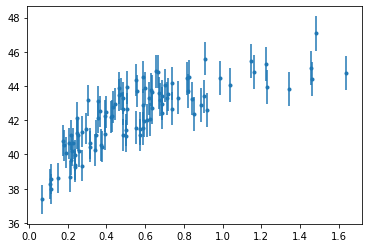

In [2]:
from astropy.cosmology import LambdaCDM
from astroML.datasets import generate_mu_z

z_sample, mu_sample, dmu = generate_mu_z(100, random_state=0)

cosmo = LambdaCDM(H0=70, Om0=0.30, Ode0=0.70, Tcmb0=0)
z = np.linspace(0.01, 2, 1000)
mu_true = cosmo.distmod(z)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.')

## Simple linear regression

Regression defined as the relation between a dependent variable, $y$, and a set of independent variables, $x$, 
that describes the expectation value of y given x: $ E[y|x] $

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form
$$
y = ax + b
$$
where $a$ is commonly known as the *slope*, and $b$ is commonly known as the *intercept*.

We can use Scikit-Learn's LinearRegression estimator to fit this data and construct the best-fit line:

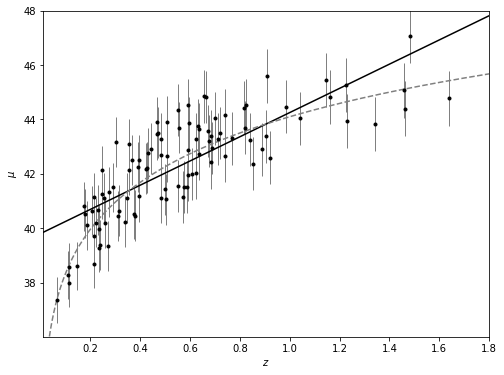

In [3]:
from sklearn.linear_model import LinearRegression as LinearRegression_sk 

linear_sk = LinearRegression_sk()
linear_sk.fit(z_sample[:,None], mu_sample)

mu_fit_sk = linear_sk.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit_sk, '-k')
ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

## Measurement errors

Modifications to LinearRegression in astroML take measurement errors into account on the dependent variable.

In [ ]:
from astroML.linear_model import LinearRegression

linear = LinearRegression()
linear.fit(z_sample[:,None], mu_sample, dmu)

mu_fit = linear.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit_sk, '-k')
ax.plot(z, mu_fit, '-k', color='red')

ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

## Basis function regression

If we consider a function in terms of the sum of bases (this can be polynomials, Gaussians, quadratics, cubics) then we can solve for the coefficients using regression. 

### Polynomial basis functions

polynomial regression: $$𝑦=𝑎_0+𝑎_1𝑥+𝑎_2𝑥^2+𝑎_3𝑥^3+⋯$$

Notice that this is still a linear model—the linearity refers to the fact that the coefficients $𝑎_𝑛$ never multiply or divide each other. What we have effectively done here is to take our one-dimensional $𝑥$ values and projected them into a higher dimension, so that a linear fit can fit more complicated relationships between $𝑥$ and $𝑦$.

In [ ]:
from astroML.linear_model import PolynomialRegression

# 2nd degree polynomial regression
polynomial = PolynomialRegression(degree=2)
polynomial.fit(z_sample[:,None], mu_sample, dmu)

mu_fit_poly = polynomial.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit_poly, '-k', color='red')

ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

### Gaussian basis functions

Of course, other basis functions are possible.
For example, one useful pattern is to fit a model that is not a sum of polynomial bases, but a sum of Gaussian bases. E.g. we could substitute $𝑥^2$ for Gaussians (where we fix $𝜎$ and $𝜇$ and fit for the amplitude) as long as the attribute we are fitting for is linear. This is called basis function regression.


In [ ]:
from astroML.linear_model import BasisFunctionRegression

#------------------------------------------------------------
# Define our number of Gaussians
nGaussians = 10
basis_mu = np.linspace(0, 2, nGaussians)[:, None]
basis_sigma = 3 * (basis_mu[1] - basis_mu[0])

gauss_basis = BasisFunctionRegression('gaussian', mu=basis_mu, sigma=basis_sigma)
gauss_basis.fit(z_sample[:,None], mu_sample, dmu)

mu_fit_gauss = gauss_basis.predict(z[:, None])

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)

ax.plot(z, mu_fit_gauss, '-k', color='red')

ax.plot(z, mu_true, '--', c='gray')
ax.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)

ax.set_xlim(0.01, 1.8)
ax.set_ylim(36.01, 48)

ax.set_ylabel(r'$\mu$')
ax.set_xlabel(r'$z$')

plt.show()

### Regularization and cross-validation

As the complexity of a model increases the data points fit the model more and more closely.

This does not result in a better fit to the data. We are overfitting the data (the model has high variance - a small change in a training point can change the model dramatically).

We can evaluate this using a training set (50-70% of sample), a cross-validation set (15-25%) and a test set (15-25%). See booko sub-chapter 8.11 and e.g. figures [8.13](http://www.astroml.org/book_figures/chapter8/fig_cross_val_B.html) and [8.14](http://www.astroml.org/book_figures/chapter8/fig_cross_val_C.html).

For cases where we are concerned with overfitting we can apply constraints (usually of smoothness, number of coefficients, size of coefficients). See book sub-chapter 8.3, and e.g. figure [8.4](http://www.astroml.org/book_figures/chapter8/fig_rbf_ridge_mu_z.html)

